## Setup

In [1]:
import pandas as pd
import numpy as np

import re

import textstat
from scipy.stats import spearmanr, pearsonr, norm
from statsmodels.api import OLS
import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

sns.set_theme()
pd.set_option('display.max_colwidth', None)

data_dir = 'resources/data/'

packages = pd.read_csv(data_dir + 'packages.csv')
packages.dropna(inplace=True, subset=['headline'])
packages['click_rate'] = packages['clicks'] / packages['impressions']
packages.reset_index(inplace=True)

[nltk_data] Downloading package punkt to /home/zmjm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zmjm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zmjm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pairwise t-statistics

The response of users depends on many factors, including the headline, the image, the time of day, the day of week, the user's mood, etc. The response is binary and stochastic, so we can model it as a Bernoulli random variable $X$ such that $X=1$ denotes that the user decides to click and $X=0$ is not to click.

To model the behavior of a group of users exposed to the same package, we can make the following assumptions:
- Each user make choice of whether to click on a headline independently
- The probability of clicking on a headline is the same for all users

The first assumption is reasonable because the users are typically independent of each other. The second assumption is not very realistic since each user should have his/her own preferences, but it is a good approximation if the number of users for the package is large.

Then the number of clicks $Y = X_1 + X_2 + ... + X_n $ out of $n$ users is a binomial random variable with parameters $n$ and $p$, where $p$ is the probability of clicking on a headline.
In practice, since the click rate is usually small, we can use a Poisson distribution to approximate the binomial distribution, therefore the variance of $Y$ is $np$ which is the same as the expected value.

From the observed $Y$, we can estimate the click rate $p$ as $\hat{p} = Y/n$ and the variance of the estimate is $\hat{p}/n$.
The t-statistic of the difference in click rate between two packages is then
$$ t = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}_1/n_1 + \hat{p}_2/n_2}} $$
where $n_1$ and $n_2$ are the number of users exposed to the two packages respectively.

Since the number of packages within a test could be more than 2, we define the pairwise t-statistic of a test as the t-statistic of the difference in click rate between two packages within the test. Then we can perform a t-test on the pairwise t-statistics to determine whether the difference in click rate between two packages is statistically significant.

Additionally, since we want to study the effect of headline, we can look into the pair of packages that are different only by their headlines.

In [2]:
tests = packages.groupby('test_id', group_keys=False)
t_stat = pd.DataFrame(columns=['test_id', 'A_package_id', 'B_package_id', 'A_headline', 'B_headline', 't', 'A_click_rate', 'B_click_rate', 'A_impressions', 'B_impressions'])

for test_id, test in tqdm(tests):
    if len(test) >= 2:
        num_packages = len(test)
        
        for i in range(num_packages - 1):
            for j in range(i + 1, num_packages):

                test_a, test_b = test.iloc[i], test.iloc[j]
                
                if test_a.click_rate == 0 and test_b.click_rate == 0:
                    continue

                if test_a.headline == test_b.headline:
                    continue

                if test_a.image_id != test_b.image_id:
                    continue
                
                t = (test_a.click_rate - test_b.click_rate) / np.sqrt(
                    test_a.click_rate/test_a.impressions + test_b.click_rate/test_b.impressions)
                
                if t > 0:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[i], test.index[j], test_a.headline.lower(), test_b.headline.lower(), 
                                               t, test_a.click_rate, test_b.click_rate, test_a.impressions, test_b.impressions]
                else:
                    t_stat.loc[len(t_stat)] = [test_id, test.index[j], test.index[i], test_b.headline.lower(), test_a.headline.lower(), 
                                               t, test_b.click_rate, test_a.click_rate, test_b.impressions, test_a.impressions]

100%|██████████| 32487/32487 [10:14<00:00, 52.90it/s] 


In [3]:
t_stat.t.describe()

count    140621.000000
mean          0.168743
std           1.967454
min         -13.314745
25%          -1.053958
50%           0.185051
75%           1.387549
max          14.248627
Name: t, dtype: float64

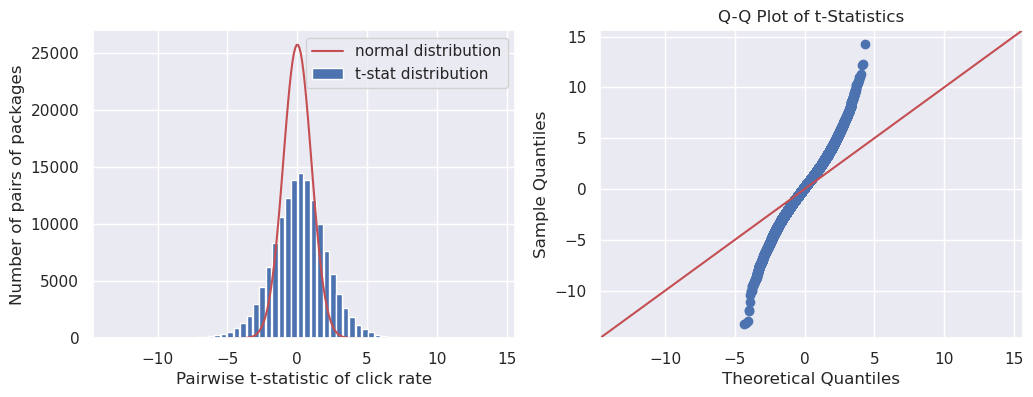

In [4]:
count, binedge = np.histogram(t_stat.t, bins=60)
bincenter = (binedge[:-1] + binedge[1:]) / 2

excess = count / norm.pdf(bincenter)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.bar(bincenter, count, width=0.4, label='t-stat distribution')
plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100), 0, 1) * len(t_stat) * (binedge[1] - binedge[0]), 'r', label='normal distribution')
plt.legend()
plt.xlabel('Pairwise t-statistic of click rate')
plt.ylabel('Number of pairs of packages')

sm.qqplot(t_stat.t, line='45', ax=plt.subplot(122))
plt.title('Q-Q Plot of t-Statistics')
plt.show()

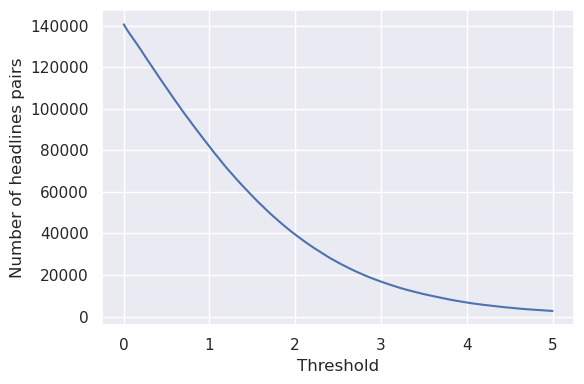

In [5]:
thresholds = np.linspace(0, 5, 100)
size = []

for threshold in thresholds:
    size.append(sum(abs(t_stat.t) > threshold))

plt.figure(figsize=(6, 4))
plt.plot(thresholds, size)
plt.xlabel('Threshold')
plt.ylabel('Number of headlines pairs')
plt.tight_layout()
plt.show()

In [6]:
sum(abs(t_stat.t) > 5) / len(t_stat)

0.019207657462256705

In [7]:
t_stat.sort_values('t', key=abs, ascending=False).head(1000).sample(20)[['A_headline', 'B_headline', 't']]

,A_headline,B_headline,t
57685,"if you’ve ever thought ‘omg, what is that person wearing!’ take 1 minute to appreciate this video",anyone who thinks you can't have too many jackets has too many jackets. but that's beside the point.,6.150804
17933,"next time you bully someone, you better hope they're not related to him","to save his sister, one boy risks everything (everything = christmas presents)",9.413849
129723,this preschooler called 911 and what she told the dispatcher blew me away,"when her mom had a seizure, this 4-year-old knew exactly what to do. parenting goals.",-6.941703
12025,missed obama’s major announcement on climate change? shoulda been watching jon stewart.,"hey cnn, are you sure you want to let jay leno beat you on presidential news coverage?",6.254110
108732,millions of people have looked at this painting. why did it take 125 years for us to see it?,it's too easy to say that madness let him see the truth ... right?,7.109959
45938,"how a kid got revenge on his bully, immediately regretted it ... and regrets it, even to this day.",there's a fine line between standing up to bullying and become a bully yourself,6.007977
53580,"an adorable live cam of baby animals went horribly wrong, and it’s all our fault",a cute baby animal video that’s actually important to the fate of humanity,8.179538
71968,"here are 10 images. by the time i reached the 3rd one, i was crying. by the 10th, i was furious.",sad. angry. outraged. that's we should all feel when we look at 10 simple but powerful images.,6.654839
23224,fast food usually grosses me out. but this video changed that for 2 minutes and 10 seconds.,can fast food really be good for the soul? these guys think so.,6.575613
51025,here are 3 text messages that never should have been sent.,social media can drive new business….even for a morgue.,-8.651608


## Language complexity measure

- Type-token ratio: https://en.wikipedia.org/wiki/Lexical_diversity#Type%E2%80%93token_ratio
- Flesch-Kincaid Grade Level: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level
- Word complexity: https://en.wikipedia.org/wiki/Lexical_density

### Type-token ratio

In [23]:
def get_TTR(texts, random_state=0, curve=True, num_tokens=None):
    texts = texts.sample(frac=1, random_state=random_state)
    vocab = dict()
    tokens = 0
    ttr = []

    for text in tqdm(texts):
        text = re.sub(r'[^\w\s]', '', text)
        words = word_tokenize(text)
        for word in words:
            if word.isalpha():
                if word not in vocab:
                    vocab[word] = 1
                else:
                    vocab[word] += 1
                tokens += 1
                ttr.append(len(vocab) / tokens)
                
                if num_tokens is not None and tokens >= num_tokens:
                    if not curve:
                        return ttr[-1], vocab, tokens
                    else:
                        return ttr, vocab, tokens
    if not curve:        
        return ttr[-1], vocab, tokens
    else:
        return ttr, vocab, tokens

def split_headlines(t_stat, threshold):
    good_headlines = t_stat.A_headline[abs(t_stat.t) > threshold]
    bad_headlines = t_stat.B_headline[abs(t_stat.t) > threshold]

    good_headlines = good_headlines.sample(frac=1, random_state=0)
    bad_headlines = bad_headlines.sample(frac=1, random_state=0)

    mixed_headlines = pd.concat([good_headlines, bad_headlines], ignore_index=True).sample(frac=1, random_state=0)

    good_headlines_unique = pd.Series(good_headlines.unique())
    bad_headlines_unique = pd.Series(bad_headlines.unique())

    print('good_headlines: {}, bad_headlines: {}, good_headlines_unique: {}, bad_headlines_unique: {}'.format(
        good_headlines.shape[0], bad_headlines.shape[0], good_headlines_unique.shape[0], bad_headlines_unique.shape[0]))
    
    return {'good': good_headlines, 'bad': bad_headlines, 'good_unique': good_headlines_unique, 'bad_unique': bad_headlines_unique, 'mixed': mixed_headlines}

In [24]:
thresholds = [0, 1, 2, 3, 4, 5]
# threshold = [5]

num_tokens = 2e4
num_samples = 10

ttr_record = dict()
vocab_record = dict()

ttr = dict()

for i, threshold in enumerate(thresholds):
    corpus = split_headlines(t_stat, threshold=threshold)
    ttr[threshold] = dict()
    ttr_record[threshold] = dict()
    vocab_record[threshold] = dict()

    for text in ['good', 'bad', 'good_unique', 'bad_unique', 'mixed']:
        ttr[threshold][text], _, _ = get_TTR(corpus[text])

        new_record = []
        for j in range(num_samples):
            new_record.append(get_TTR(corpus[text], random_state=j, curve=False, num_tokens=num_tokens)[0])
        ttr_record[threshold][text] = new_record
        vocab_record[threshold][text] = get_TTR(corpus[text], curve=False, num_tokens=num_tokens)[1]

ttr_record = pd.DataFrame(ttr_record).T
vocab_record = pd.DataFrame(vocab_record).T

good_headlines: 140594, bad_headlines: 140594, good_headlines_unique: 48715, bad_headlines_unique: 53683


  0%|          | 1348/281188 [00:00<00:13, 21443.99it/s]


good_headlines: 81791, bad_headlines: 81791, good_headlines_unique: 34402, bad_headlines_unique: 39827


  1%|          | 1363/163582 [00:00<00:07, 20687.69it/s]


good_headlines: 39455, bad_headlines: 39455, good_headlines_unique: 19741, bad_headlines_unique: 23482


  2%|▏         | 1371/78910 [00:00<00:03, 21004.92it/s]


good_headlines: 16808, bad_headlines: 16808, good_headlines_unique: 9595, bad_headlines_unique: 11532


  4%|▍         | 1358/33616 [00:00<00:01, 21137.13it/s]


good_headlines: 6757, bad_headlines: 6757, good_headlines_unique: 4214, bad_headlines_unique: 5103


 10%|▉         | 1340/13514 [00:00<00:00, 21196.94it/s]


good_headlines: 2701, bad_headlines: 2701, good_headlines_unique: 1812, bad_headlines_unique: 2178


 25%|██▌       | 1362/5402 [00:00<00:00, 21544.54it/s]


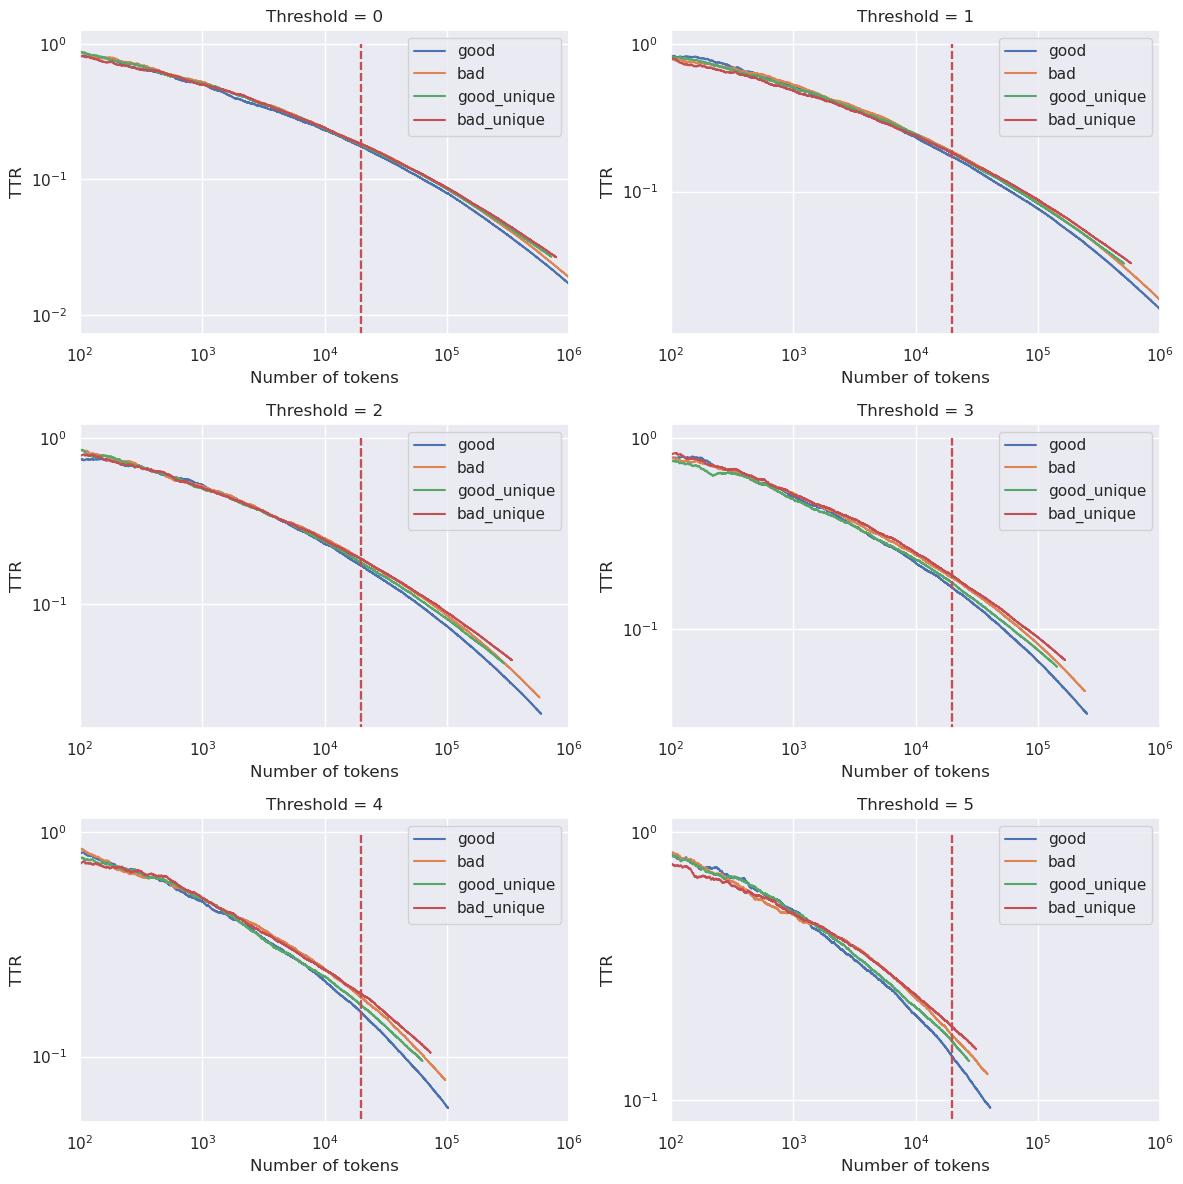

In [25]:
plt.figure(figsize=(12, 12))

for i, threshold in enumerate(thresholds):
    plt.subplot(3, 2, i + 1)
    plt.plot(ttr[threshold]['good'], label='good')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['bad'], label='bad')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['good_unique'], label='good_unique')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.plot(ttr[threshold]['bad_unique'], label='bad_unique')
    plt.vlines(2e4, 0, 1, linestyles='dashed', colors='r')
    plt.xlim(1e2, 1e6)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Number of tokens')
    plt.ylabel('TTR')
    plt.title('Threshold = {}'.format(threshold))

plt.tight_layout()
plt.show()

In [26]:
ttr_record_mean = ttr_record.apply(lambda x: x.apply(np.mean))
ttr_record_mean

,good,bad,good_unique,bad_unique,mixed
0,0.174200,0.183405,0.180645,0.183940,0.179450
1,0.172405,0.183945,0.178060,0.186120,0.178490
2,0.167355,0.185430,0.175515,0.187250,0.177750
3,0.161815,0.184800,0.171595,0.187955,0.177570
4,0.155150,0.181565,0.168240,0.188800,0.172525
5,0.143200,0.174460,0.161585,0.187350,0.166240


In [27]:
ttr_record_std = ttr_record.apply(lambda x: x.apply(np.std))
ttr_record_std

,good,bad,good_unique,bad_unique,mixed
0,0.000699,0.001561,0.002190,0.002251,0.001891
1,0.001284,0.002388,0.002346,0.002503,0.002242
2,0.001513,0.002450,0.001681,0.001645,0.001808
3,0.001680,0.001536,0.001528,0.002133,0.002182
4,0.001424,0.001622,0.002036,0.001229,0.001614
5,0.001458,0.001128,0.001654,0.000867,0.002063


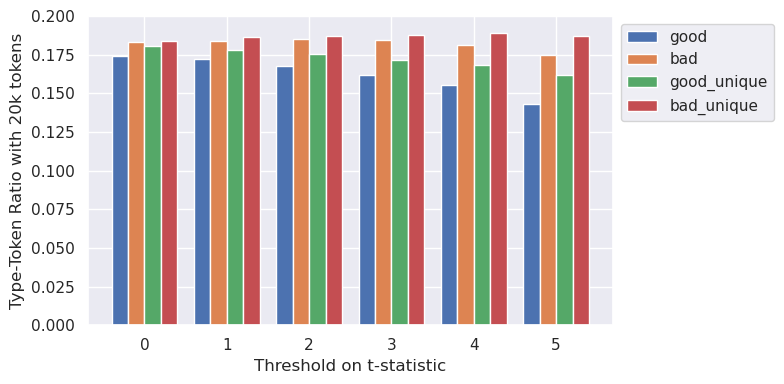

In [28]:
plt.figure(figsize=(8, 4))

indices = np.arange(len(ttr_record_mean['good']))

plt.bar(indices - 0.3, ttr_record_mean['good'], width=0.2, label='good')
plt.bar(indices - 0.1, ttr_record_mean['bad'], width=0.2, label='bad')
plt.bar(indices + 0.1, ttr_record_mean['good_unique'], width=0.2, label='good_unique')
plt.bar(indices + 0.3, ttr_record_mean['bad_unique'], width=0.2, label='bad_unique')
# plt.bar(indices + 0.5, ttr_record['mixed'], width=0.2, label='mixed')

# move the legend to the upper left corner
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Threshold on t-statistic')
plt.ylabel('Type-Token Ratio with 20k tokens')
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()

In [50]:
good_bad = abs(ttr_record_mean['good'] - ttr_record_mean['bad']) / (ttr_record_std['good']**2 + ttr_record_std['bad']**2)**0.5
good_bad_unique = abs(ttr_record_mean['good_unique'] - ttr_record_mean['bad_unique']) / (ttr_record_std['good_unique']**2 + ttr_record_std['bad_unique']**2)**0.5

good_bad, good_bad_unique

(0     5.380626
 1     4.256752
 2     6.277584
 3    10.096569
 4    12.237793
 5    16.958353
 dtype: float64,
 0     1.049016
 1     2.349395
 2     4.989993
 3     6.235402
 4     8.645527
 5    13.798560
 dtype: float64)

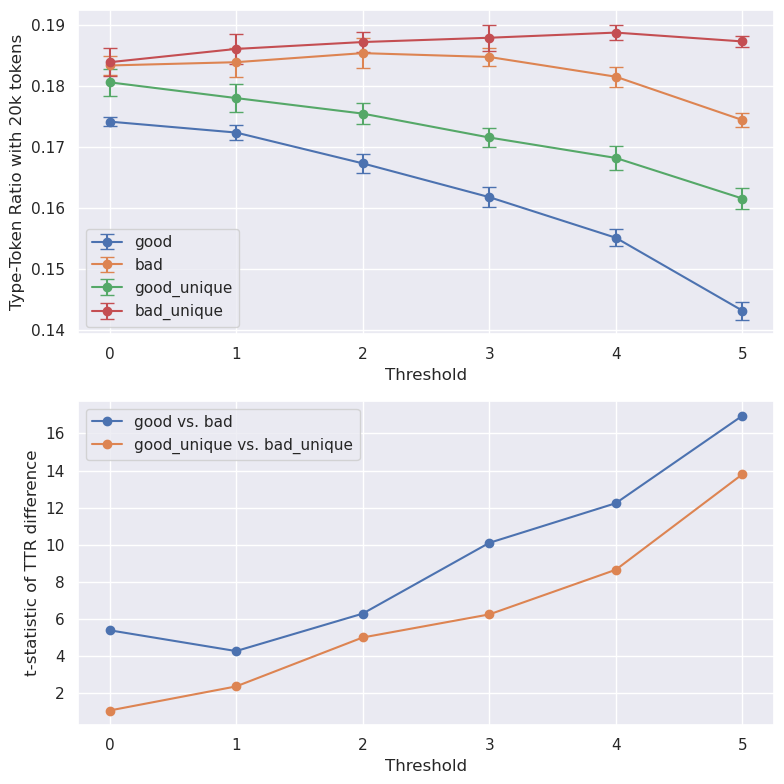

In [51]:
plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.errorbar(indices, ttr_record_mean['good'], ttr_record_std['good'], fmt='o-', capsize=5, label='good')
plt.errorbar(indices, ttr_record_mean['bad'], ttr_record_std['bad'], fmt='o-', capsize=5, label='bad')
plt.errorbar(indices, ttr_record_mean['good_unique'], ttr_record_std['good_unique'], fmt='o-', capsize=5, label='good_unique')
plt.errorbar(indices, ttr_record_mean['bad_unique'], ttr_record_std['bad_unique'], fmt='o-', capsize=5, label='bad_unique')
# plt.errorbar(indices + 0.5, ttr_record_mean['mixed'], ttr_record_std['mixed'], fmt='o', label='mixed')

# move the legend to the lower left corner
plt.legend(loc='lower left', bbox_to_anchor=(0, 0))
plt.xlabel('Threshold')
plt.ylabel('Type-Token Ratio with 20k tokens')

plt.subplot(212)
plt.plot(indices, good_bad, 'o-', label='good vs. bad')
plt.plot(indices, good_bad_unique, 'o-', label='good_unique vs. bad_unique')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('t-statistic of TTR difference')

plt.tight_layout()
plt.show()

In [30]:
ttr_record_mean * 2e4

,good,bad,good_unique,bad_unique,mixed
0,3484.0,3668.1,3612.9,3678.8,3589.0
1,3448.1,3678.9,3561.2,3722.4,3569.8
2,3347.1,3708.6,3510.3,3745.0,3555.0
3,3236.3,3696.0,3431.9,3759.1,3551.4
4,3103.0,3631.3,3364.8,3776.0,3450.5
5,2864.0,3489.2,3231.7,3747.0,3324.8


### Vocabulary, word frequency

In [39]:
headlines = pd.Series(packages.headline.unique())

vocab = dict()

for headline in tqdm(headlines):
    headline = re.sub(r'[^\w\s]', '', headline).lower()
    words = word_tokenize(headline)
    for word in words:
        if word.isalpha():
            if word not in vocab:
                vocab[word] = 1
            else:
                vocab[word] += 1

  0%|          | 0/65362 [00:00<?, ?it/s]

100%|██████████| 65362/65362 [00:03<00:00, 21570.59it/s]


In [40]:
vocab = pd.Series(vocab)
vocab.sort_values(ascending=False, inplace=True)
vocab

the            33371
a              33220
to             27340
of             15932
you            15383
               ...  
laces              1
manipulates        1
spoils             1
indignation        1
wanders            1
Length: 22031, dtype: int64

In [41]:
vocab_freq = vocab / vocab.sum()
vocab_freq

the            0.035042
a              0.034884
to             0.028709
of             0.016730
you            0.016153
                 ...   
laces          0.000001
manipulates    0.000001
spoils         0.000001
indignation    0.000001
wanders        0.000001
Length: 22031, dtype: float64

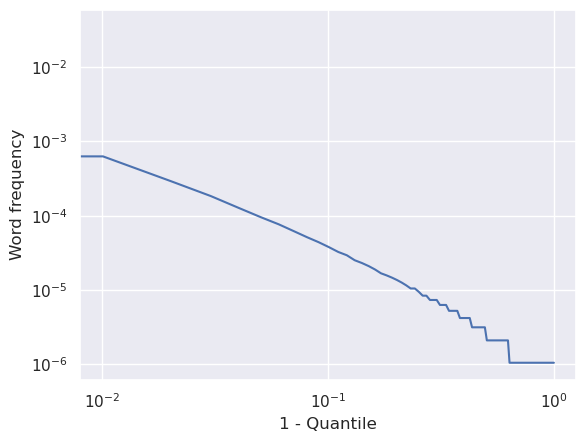

In [60]:
plt.plot(1-np.linspace(0, 1, 100), vocab_freq.quantile(np.linspace(0, 1, 100)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('1 - Quantile')
plt.ylabel('Word frequency')
plt.show()

In [61]:
num_words = 3000
vocab_freq[:num_words].sum()

0.9185481542152987

In [62]:
vocab_freq_log = vocab_freq.apply(np.log)
vocab_freq_log

the            -3.351198
a              -3.355733
to             -3.550535
of             -4.090556
you            -4.125622
                 ...    
laces         -13.766641
manipulates   -13.766641
spoils        -13.766641
indignation   -13.766641
wanders       -13.766641
Length: 22031, dtype: float64

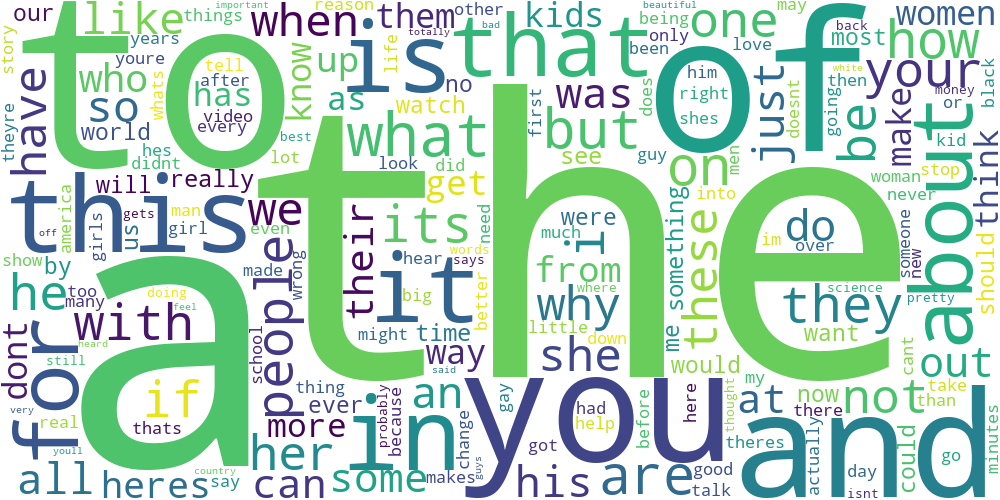

In [63]:
wordcloud = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate_from_frequencies(vocab_freq[:200])
wordcloud.to_image()

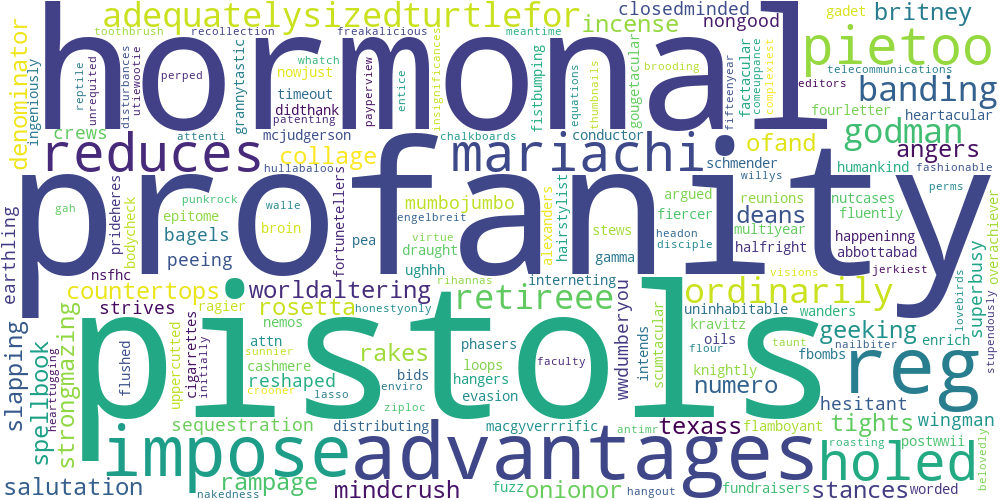

In [64]:
wordcloud = WordCloud(width=1000, height=500, background_color='white', min_font_size=10).generate_from_frequencies(vocab_freq[-1000:].sample(200).apply(lambda x: 1 - x))
wordcloud.to_image()

In [67]:
def headline_score(headline):
    headline = re.sub(r'[^\w\s]', '', headline).lower()
    words = word_tokenize(headline)
    freq_list = [vocab_freq_log[word] for word in words if word.isalpha()]
    return min(freq_list) if len(freq_list) > 0 else np.nan

In [68]:
tqdm.pandas()
t_stat['A_score'] = t_stat.A_headline.progress_apply(headline_score)

tqdm.pandas()
t_stat['B_score'] = t_stat.B_headline.progress_apply(headline_score)

100%|██████████| 140621/140621 [00:08<00:00, 16037.88it/s]


In [85]:
t_stat.dropna(inplace=True)
t_stat.describe()

,A_package_id,B_package_id,t,A_click_rate,B_click_rate,A_impressions,B_impressions,A_score,B_score
count,140617.000000,140617.000000,140617.000000,140617.000000,140617.000000,140617.000000,140617.000000,140617.000000,140617.000000
mean,76709.850203,76399.733837,0.168846,0.015406,0.011149,3591.170399,3591.709175,-11.203632,-11.353695
std,43597.179560,43610.734625,1.967381,0.011880,0.009814,1419.103630,1418.784829,1.431795,1.482676
min,12.000000,12.000000,-13.314745,0.000220,0.000000,13.000000,1.000000,-13.766641,-13.766641
25%,38710.000000,38414.000000,-1.053830,0.007554,0.004874,2766.000000,2771.000000,-12.157203,-12.380346
50%,79865.000000,79249.000000,0.185101,0.012156,0.008304,3143.000000,3141.000000,-11.201691,-11.368745
75%,113649.000000,113185.000000,1.387559,0.019417,0.014079,4111.000000,4113.000000,-10.155723,-10.270133
max,150797.000000,150796.000000,14.248627,0.153846,0.132267,26841.000000,26841.000000,-6.008307,-5.905684


In [117]:
indices = np.linspace(-16, -6, 20)
A_count = np.histogram(t_stat.A_score, bins=indices)[0]
B_count = np.histogram(t_stat.B_score, bins=indices)[0]

                                 OLS Regression Results                                
Dep. Variable:             score_diff   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              1491.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:39:09   Log-Likelihood:                     -2.8453e+05
No. Observations:              140617   AIC:                                  5.691e+05
Df Residuals:                  140616   BIC:                                  5.691e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/tmp/ipykernel_1770409/3829201396.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(np.linspace(-10, 10, 100), result.params[0] * np.linspace(-10, 10, 100), 'r', linestyle='dashed')
/tmp/ipykernel_1770409/3829201396.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(4, 10, 'slope = {:.4f}\nR squared = {:.3f}'.format(result.params[0], result.rsquared), color='r')


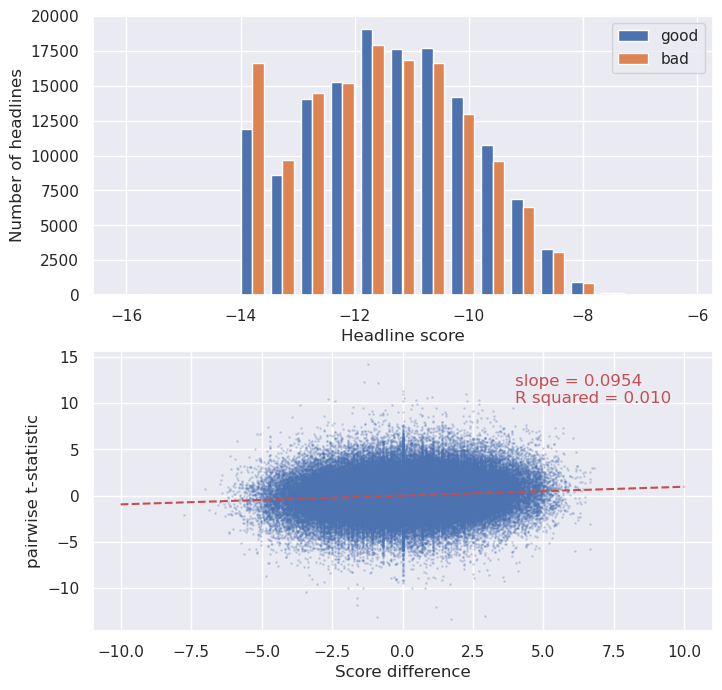

In [125]:
t_stat['score_diff'] = t_stat.apply(lambda x: x.A_score - x.B_score if x.t > 0 else x.B_score - x.A_score, axis=1)
result = OLS(t_stat.score_diff, t_stat.t).fit()
print(result.summary())

plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.bar(indices[:-1], A_count, width=0.2, label='good')
plt.bar(indices[:-1] + 0.2, B_count, width=0.2, label='bad')

plt.legend()
plt.xlabel('Headline score')
plt.ylabel('Number of headlines')

plt.subplot(212)
plt.scatter(t_stat.score_diff, t_stat.t, s=1, alpha=0.2)
plt.plot(np.linspace(-10, 10, 100), result.params[0] * np.linspace(-10, 10, 100), 'r', linestyle='dashed')
plt.text(4, 10, 'slope = {:.4f}\nR squared = {:.3f}'.format(result.params[0], result.rsquared), color='r')
plt.xlabel('Score difference')
plt.ylabel('pairwise t-statistic')
plt.show()

In [107]:
pearsonr(t_stat.score_diff, t_stat.t)

PearsonRResult(statistic=0.1001249312617178, pvalue=4.7576140192549e-310)